In [0]:
from google.colab import drive
import pandas as pd
import io
import keras
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from keras.models import load_model
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, SpatialDropout2D, MaxoutDense, SpatialDropout1D
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers.advanced_activations import PReLU
from keras.regularizers import l1
from keras.constraints import max_norm
import matplotlib.pyplot as plt

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [49]:
file_list = drive.ListFile({'q': "'1w7ALbGY5CvXNDAUfxGiNq0u-vq7uMows' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: Assignment1_part2b.ipynb, id: 1sS5oqZppprrmjsrzGNv4h93yoFFZmI2L
title: Untitled0.ipynb, id: 1nmRKBkw3rvx3hI7DTB40NDIuKmYEDRiP
title: Best_cnn_model.h5, id: 1XqtppuY3F6H09roFGsQ-ww_Y7BBjYlbu
title: Assignment1_Part2.ipynb, id: 1Tg__Kp1R4V42nSx33Sn-HWdNcxsBb7kn
title: Final_cnn_model.h5, id: 1OMy5iSEEOpOrAe0mzL6F37jxoI7il0EJ
title: Assignment1.ipynb, id: 1e-XIumj5jr4dFb92_wHFD8kFubkF6s-L
title: ModelConfig.csv, id: 1b-gxJ1DMjtFkETeUMnQWlOv25NsnAmoO
title: abc.py, id: 1EG1JiGK0_EspCW-UaV3lGb1q37w4b-5x
title: Assignment1 (2).ipynb, id: 1b4dFiUC8zDCSJBNUYretMeWU_WmyHSiQ
title: Practice1.ipynb, id: 1tylakP37zWTqjm2sC5D-66iK5Ue7NJsr
title: Copy of Practice1.ipynb, id: 10uAN9_HYQwNUInf6Ve2fv7pwP9OYDPMg


In [30]:
cfg = drive.CreateFile({'id': '1b-gxJ1DMjtFkETeUMnQWlOv25NsnAmoO'})
cfg.GetContentFile('ModelConfig.csv')
df = pd.read_csv('ModelConfig.csv')
df

,Name,Value,Validations,Description
0,epochs,50,Any integer > 0,Number of iterations to train the CNN
1,batch_size,256,Any integer > 0,Number of data points taken to process togethe...
2,data_augmentation,1,0 or 1 (0 = False; 1 = True),Data augmentation performed if True
3,num_classes,10,Any integer > 0,Maximum number of final outputs available
4,workers,1,Any integer > 0,Number of threads to be executed on 1 core


In [0]:
values = df['Value']
epochs = values[0]
batch_size = values[1]
num_classes = values[3]
workers = values[4]
if values[2] == 0:
  data_augmentation = False
else:
  data_augmentation = True

In [13]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [0]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [0]:
def plotAccuracy(history):
  plt.plot(history['acc'])
  plt.plot(history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  
def plotLoss(history):
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper right')
  plt.show()

In [0]:
mdl = drive.CreateFile({'id': '1XqtppuY3F6H09roFGsQ-ww_Y7BBjYlbu'})
mdl.GetContentFile('Best_cnn_model.h5')
loade_model = load_model('Best_cnn_model.h5')
model1 = loade_model

In [52]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
p_re_lu_13 (PReLU)           (None, 32, 32, 32)        32768     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 64)        18432     
_________________________________________________________________
p_re_lu_14 (PReLU)           (None, 32, 32, 64)        65536     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
spatial_dropout2d_5 (Spatial (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 128)       73856     
__________

In [25]:
if data_augmentation:
  print('Using real-time data augmentation.')
  # This will do preprocessing and realtime data augmentation:
  datagen = ImageDataGenerator(
      featurewise_center=False,  # set input mean to 0 over the dataset
      samplewise_center=False,  # set each sample mean to 0
      featurewise_std_normalization=False,  # divide inputs by std of the dataset
      samplewise_std_normalization=False,  # divide each input by its std
      zca_whitening=False,  # apply ZCA whitening
      zca_epsilon=1e-06,  # epsilon for ZCA whitening
      rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
      # randomly shift images horizontally (fraction of total width)
      width_shift_range=0.1,
      # randomly shift images vertically (fraction of total height)
      height_shift_range=0.1,
      shear_range=0.,  # set range for random shear
      zoom_range=0.,  # set range for random zoom
      channel_shift_range=0.,  # set range for random channel shifts
      # set mode for filling points outside the input boundaries
      fill_mode='nearest',
      cval=0.,  # value used for fill_mode = "constant"
      horizontal_flip=True,  # randomly flip images
      vertical_flip=False,  # randomly flip images
      # set rescaling factor (applied before any other transformation)
      rescale=None,
      # set function that will be applied on each input
      preprocessing_function=None,
      # image data format, either "channels_first" or "channels_last"
      data_format=None,
      # fraction of images reserved for validation (strictly between 0 and 1)
      validation_split=0.0)

Using real-time data augmentation.


In [0]:
opt = keras.optimizers.adam(lr=0.0001, decay=1e-6)
model1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


In [55]:
if data_augmentation:
  datagen.fit(x_train)
  history = model1.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size), epochs=epochs,
                    validation_data=(x_test, y_test), workers=workers)
else:
  history = model1.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs, workers=workers,
              validation_data=(x_test, y_test),
              shuffle=True)

Epoch 1/50
196/196 [==============================] - 39s 200ms/step - loss: 0.2537 - acc: 0.9126 - val_loss: 0.4900 - val_acc: 0.8520
Epoch 2/50
196/196 [==============================] - 36s 182ms/step - loss: 0.2446 - acc: 0.9161 - val_loss: 0.5321 - val_acc: 0.8489
Epoch 3/50
196/196 [==============================] - 36s 183ms/step - loss: 0.2422 - acc: 0.9179 - val_loss: 0.4951 - val_acc: 0.8557
Epoch 4/50
196/196 [==============================] - 36s 182ms/step - loss: 0.2390 - acc: 0.9178 - val_loss: 0.4957 - val_acc: 0.8508
Epoch 5/50
196/196 [==============================] - 36s 182ms/step - loss: 0.2298 - acc: 0.9206 - val_loss: 0.4936 - val_acc: 0.8503
Epoch 6/50
196/196 [==============================] - 36s 182ms/step - loss: 0.2292 - acc: 0.9216 - val_loss: 0.4716 - val_acc: 0.8544
Epoch 7/50
196/196 [==============================] - 36s 181ms/step - loss: 0.2279 - acc: 0.9215 - val_loss: 0.4694 - val_acc: 0.8571
Epoch 8/50
196/196 [==============================] - 3

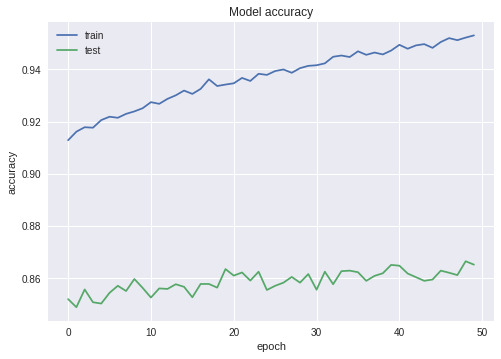

In [56]:
plotAccuracy(history.history)

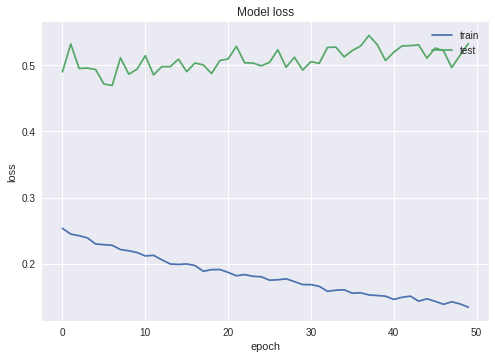

In [57]:
plotLoss(history.history)

In [58]:
model2 = loade_model
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
p_re_lu_13 (PReLU)           (None, 32, 32, 32)        32768     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 64)        18432     
_________________________________________________________________
p_re_lu_14 (PReLU)           (None, 32, 32, 64)        65536     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
spatial_dropout2d_5 (Spatial (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 128)       73856     
__________

In [0]:
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
model2.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

In [61]:
history2 = model2.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size), epochs=epochs,
                    validation_data=(x_test, y_test), workers=workers)

Epoch 1/50
196/196 [==============================] - 38s 192ms/step - loss: 0.0073 - acc: 0.9512 - val_loss: 0.0216 - val_acc: 0.8623
Epoch 2/50
196/196 [==============================] - 35s 180ms/step - loss: 0.0073 - acc: 0.9510 - val_loss: 0.0216 - val_acc: 0.8631
Epoch 3/50
196/196 [==============================] - 35s 180ms/step - loss: 0.0072 - acc: 0.9519 - val_loss: 0.0217 - val_acc: 0.8593
Epoch 4/50
196/196 [==============================] - 35s 179ms/step - loss: 0.0072 - acc: 0.9521 - val_loss: 0.0207 - val_acc: 0.8675
Epoch 5/50
196/196 [==============================] - 35s 180ms/step - loss: 0.0071 - acc: 0.9529 - val_loss: 0.0213 - val_acc: 0.8650
Epoch 6/50
196/196 [==============================] - 35s 180ms/step - loss: 0.0071 - acc: 0.9521 - val_loss: 0.0208 - val_acc: 0.8671
Epoch 7/50
196/196 [==============================] - 35s 179ms/step - loss: 0.0069 - acc: 0.9536 - val_loss: 0.0219 - val_acc: 0.8594
Epoch 8/50
196/196 [==============================] - 3

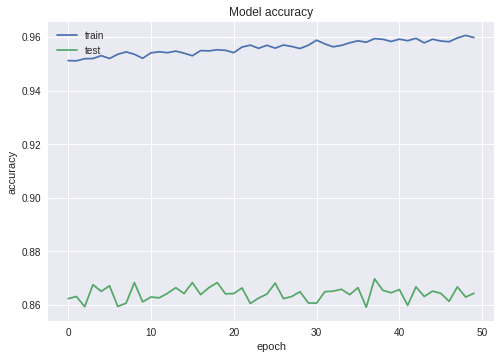

In [62]:
plotAccuracy(history2.history)

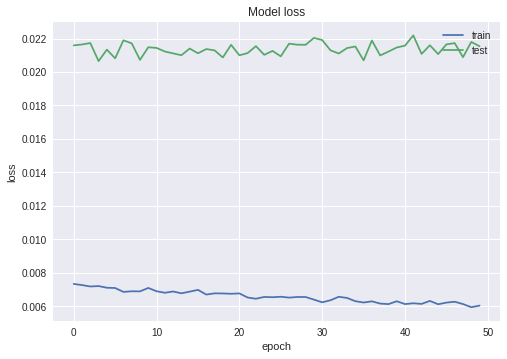

In [63]:
plotLoss(history2.history)

In [83]:
model5 = loade_model
model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
p_re_lu_13 (PReLU)           (None, 32, 32, 32)        32768     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 64)        18432     
_________________________________________________________________
p_re_lu_14 (PReLU)           (None, 32, 32, 64)        65536     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
spatial_dropout2d_5 (Spatial (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 128)       73856     
__________

In [0]:
opt = keras.optimizers.rmsprop(lr=0.0002, decay=1e-6)
model5.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [87]:
history5 = model5.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size), epochs=epochs,
                    validation_data=(x_test, y_test), workers=workers)

Epoch 1/50
196/196 [==============================] - 39s 201ms/step - loss: 0.3246 - acc: 0.8901 - val_loss: 0.5582 - val_acc: 0.8425
Epoch 2/50
196/196 [==============================] - 35s 180ms/step - loss: 0.3133 - acc: 0.8933 - val_loss: 0.5386 - val_acc: 0.8465
Epoch 3/50
196/196 [==============================] - 36s 181ms/step - loss: 0.3077 - acc: 0.8948 - val_loss: 0.4790 - val_acc: 0.8565
Epoch 4/50
196/196 [==============================] - 35s 180ms/step - loss: 0.3073 - acc: 0.8955 - val_loss: 0.5167 - val_acc: 0.8389
Epoch 5/50
196/196 [==============================] - 35s 181ms/step - loss: 0.3044 - acc: 0.8960 - val_loss: 0.4819 - val_acc: 0.8503
Epoch 6/50
196/196 [==============================] - 35s 180ms/step - loss: 0.2968 - acc: 0.8977 - val_loss: 0.5072 - val_acc: 0.8404
Epoch 7/50
196/196 [==============================] - 35s 180ms/step - loss: 0.2925 - acc: 0.8990 - val_loss: 0.6002 - val_acc: 0.8405
Epoch 8/50
196/196 [==============================] - 3

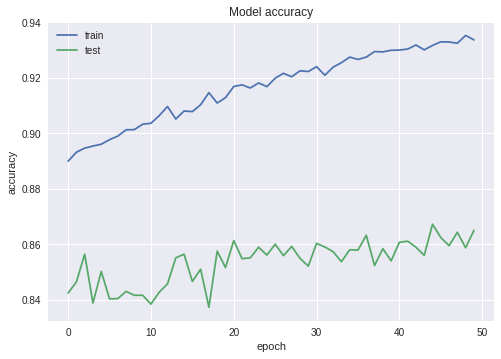

In [88]:
plotAccuracy(history5.history)

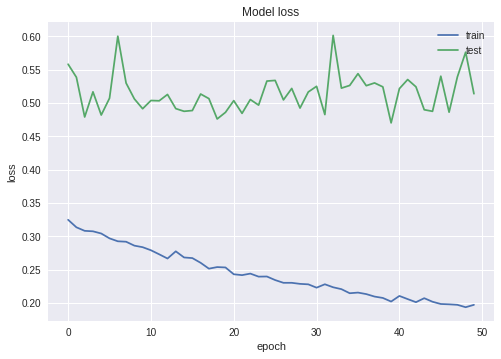

In [89]:
plotLoss(history5.history)